<h3><b>Statistical analisys of Gesture Recognizer App</b></h3>

This application lets the user create saveable configurations in which he can bind commands to one or more gestures.
Both commands and gesture belong to predefined sets.
In this notebook, we have examined the following statistics: 

- The frequency of commands for each gesture and its contingency matrix
- Most frequently used gestures in configurations
- Most used commands across all gestures
- Commands assigned to multiple gestures (summed across all configurations)

In order to create these graphs, we used a combination of Matplotlib, Pandas and Seaborn.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json

# This script reads JSON files from a specified directory, converts them into pandas DataFrames,
# and concatenates them into a single DataFrame. It then prints the first 5 rows of the resulting DataFrame.
file_list = glob.glob('../client/static/configs/*.json')

df_list = []
for file in file_list:
    with open(file, 'r') as f:
        data = json.load(f)
        df_list.append(pd.DataFrame([data]))
# ignore_index=True to reset the index in the concatenated DataFrame.
# pandas creates a new increasing index (0, 1 , 2, ...) for the resulting DataFrame. 
full_df = pd.concat(df_list, ignore_index=True)
# print(full_df.head())

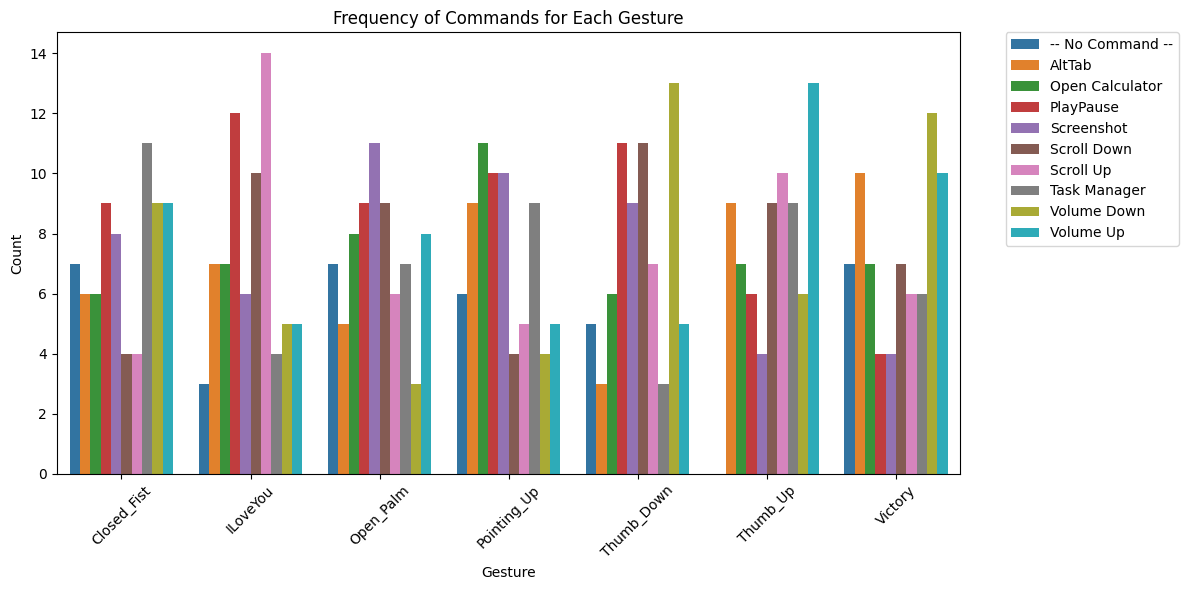

In [32]:
# Convert the DataFrame to a long format for easier plotting
# We use this to use a single column for gestures and another for commands.
# This allows us to easily count the occurrences of each command for each gesture.
long_df = full_df.melt(var_name='Gesture', value_name='Command')
# reset_index to ensure that the index is reset after melting
# after group by, the new indexes will be 0, 1, 2, ... for each unique combination of Gesture and Command. 
counts_df = long_df.groupby(['Gesture', 'Command']).size().reset_index(name='Count')

# print(counts_df.head())


import seaborn as sns

# Set the style of seaborn
plt.figure(figsize=(12, 6))
# Hue is used to differentiate between commands
sns.barplot(data=counts_df, x='Gesture', y='Count', hue='Command')
plt.title("Frequency of Commands for Each Gesture")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# tight_layout to ensure that the plot fits well within the figure area
plt.tight_layout()
plt.show()

This graph let us see the frequency with which each command is associated to every gesture.
As we can see (and we could've intuitively expected):
- the Thumb_Up gesture is often associated with Volume Up command and Thumb_down is instead often associated with Volume Down command
- the Open_Palm gesture is often associated with Scroll UP command and Closed_Fist is instead often associated with Scroll Down command.

This doesn't surprise us because it is quite natural to associate the motion of the thumb up with the increase in volume and the opposite for lowering it.

There are a lot of combinations of "Scroll Up --> Closed_Fist" and "Scroll Down --> Open_Palm". This preference may be linked to the inverted controls setting that appears in some video games.

Open_Palm is also quite often used with PlayPause command. This is natural because you may want to stop a video by simply raising your arm with your hand relaxed.

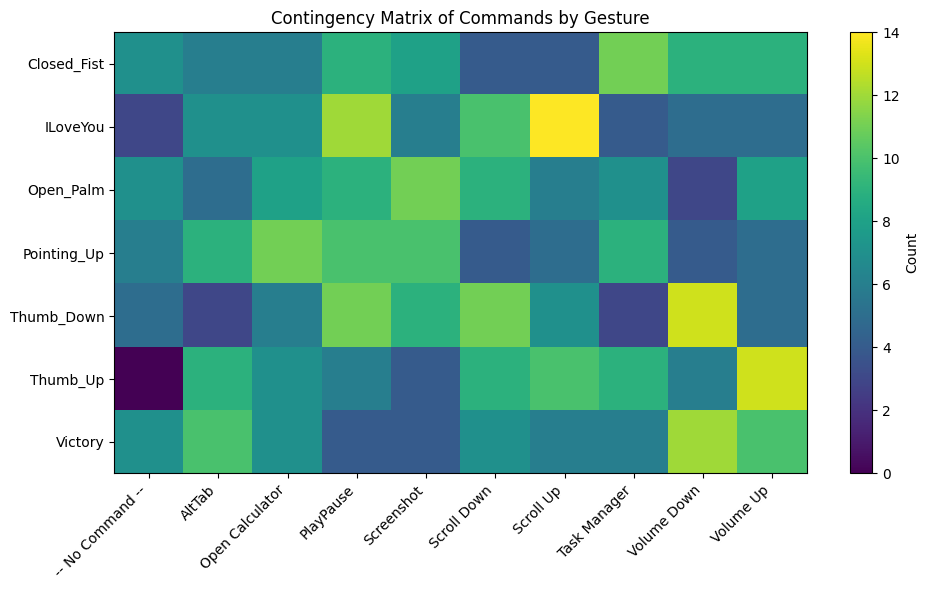

In [27]:
# matrix of contingency counts
# This will create a matrix where rows are gestures and columns are commands,
# and the values are the counts of each command for each gesture.
# We use pivot to reshape the DataFrame into a matrix format.
# The index will be the 'Gesture', the columns will be the 'Command', and the values will be the 'Count'.
# fillna(0) is used to replace NaN values
cont_matrix = counts_df.pivot(index='Gesture',
                              columns='Command',
                              values='Count') \
                       .fillna(0)

# Plot the contingency matrix
plt.figure(figsize=(10, 6))

# aspect='auto' allows the matrix to be displayed with equal aspect ratio
# This means that the cells will be square, making it easier to visualize the counts.
plt.imshow(cont_matrix, aspect='auto')
plt.colorbar(label='Count')

# Set the ticks and labels for the x and y axes
# We use range(len(...)) to get the positions for the ticks,
# and we use the index and columns of the DataFrame for the labels.
# rotation=45 and ha='right' to make the labels more readable.
plt.xticks(range(len(cont_matrix.columns)),
           cont_matrix.columns,
           rotation=45, ha='right')
plt.yticks(range(len(cont_matrix.index)),
           cont_matrix.index)
plt.title("Contingency Matrix of Commands by Gesture")
plt.tight_layout()
plt.show()


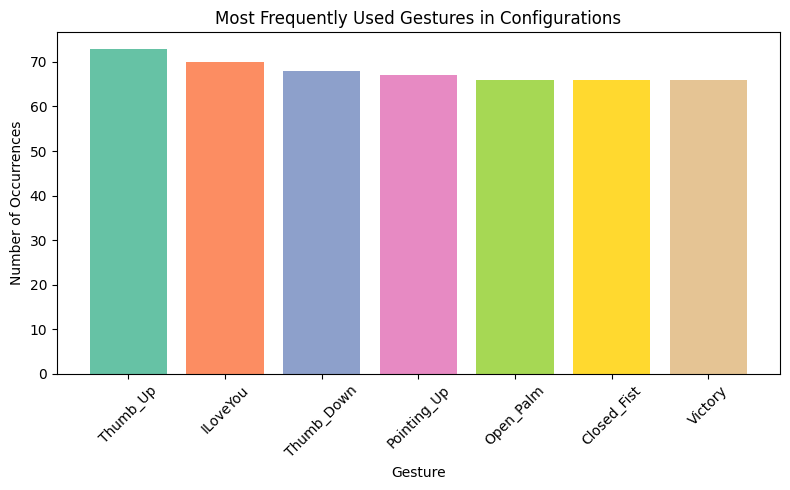

In [28]:
# Remove gestures associated with '-- No Command --'
long_df = long_df[long_df['Command'] != '-- No Command --']

# Count how many times each gesture appears across all configurations
# This tells us how frequently each gesture has been assigned to any command
gesture_counts = long_df['Gesture'].value_counts().reset_index()
gesture_counts.columns = ['Gesture', 'Count']

# Create a distinct color for each gesture using a seaborn palette
palette = sns.color_palette("Set2", len(gesture_counts))

# Create a bar plot showing the most frequently used gestures
plt.figure(figsize=(8, 5))
plt.bar(gesture_counts['Gesture'], gesture_counts['Count'], color=palette)
plt.title('Most Frequently Used Gestures in Configurations')
plt.xlabel('Gesture')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

           Command  Count
0        PlayPause     61
1        Volume Up     55
2      Scroll Down     54
3       Screenshot     52
4        Scroll Up     52
5  Open Calculator     52
6      Volume Down     52
7           AltTab     49
8     Task Manager     49


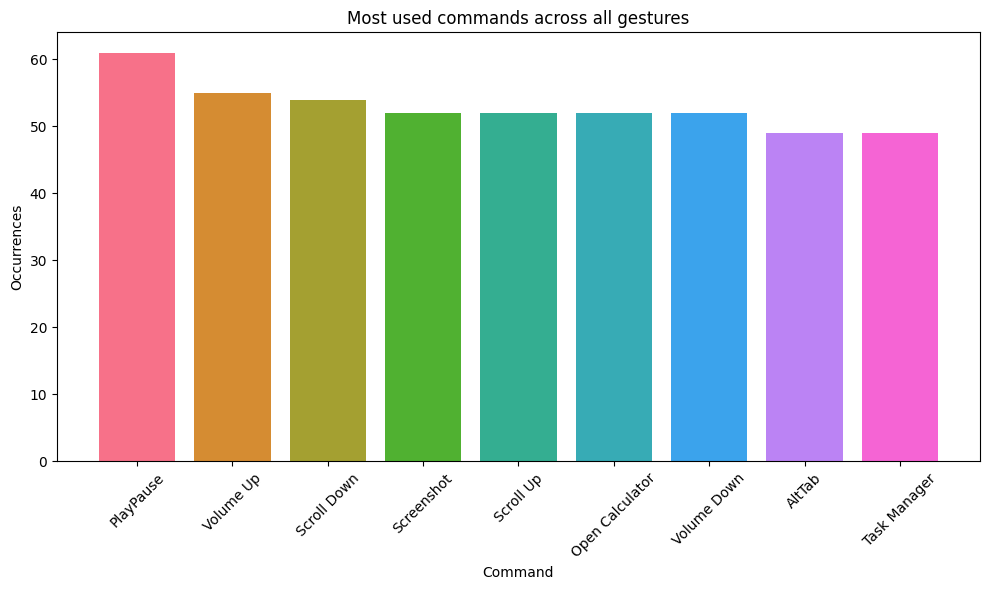

In [29]:
# Count the occurrences of each command across all gestures
# This will give us a summary of how many times each command is used.
# We can use this to create a bar chart of the most used commands.
command_counts = long_df['Command'].value_counts().reset_index()
command_counts.columns = ['Command', 'Count']
print(command_counts)

# Generate a different color for each command
# You can use seaborn or matplotlib colormaps
import seaborn as sns
palette = sns.color_palette("husl", len(command_counts))  # distinct colors

# Bar chart of the most used commands
plt.figure(figsize=(10, 6))
plt.bar(command_counts['Command'], command_counts['Count'], color=palette)
plt.title('Most used commands across all gestures')
plt.xlabel('Command')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


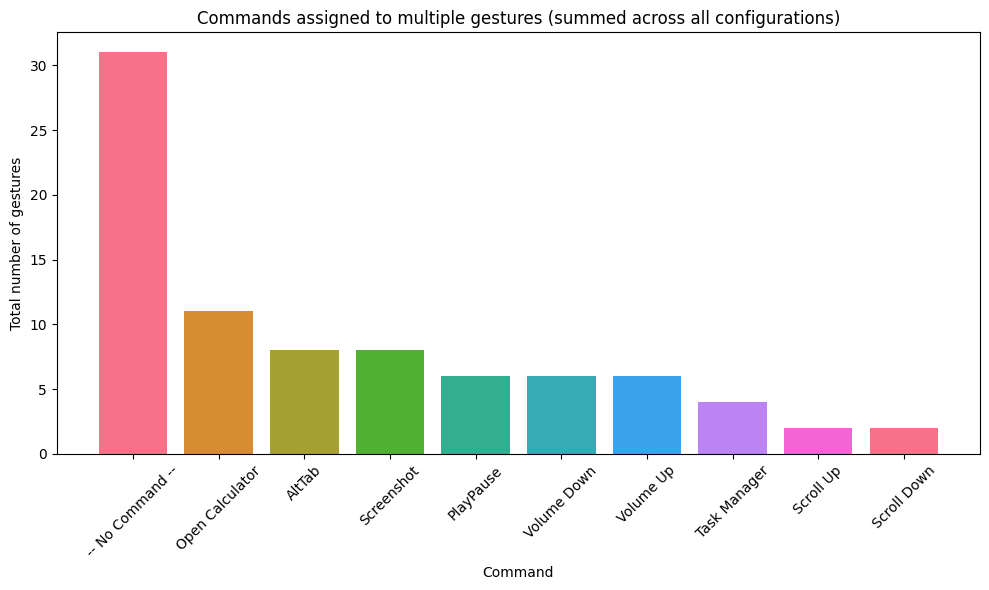

In [30]:
from collections import Counter, defaultdict

# Dictionary: maps each command to the total number of gestures
# that have been associated with it in a single configuration (only when a command is used multiple times in one config)
command_to_multi_gestures = defaultdict(int)

# Iterate over each configuration (each row is a config with gesture-command mappings)
for row in full_df.itertuples(index=False):
    # Convert the row to a dictionary: {gesture: command}
    gesture_to_command = row._asdict()

    # Count how many gestures are assigned to each command in this configuration
    command_counts = Counter(gesture_to_command.values())

    # For each command used more than once in a single configuration (i.e. shared by multiple gestures),
    # add the number of gestures it was assigned to into the total counter
    for cmd, n in command_counts.items():
        if n > 1:
            command_to_multi_gestures[cmd] += n

# Convert the result to a DataFrame for visualization
plot_df = pd.DataFrame(command_to_multi_gestures.items(), columns=['Command', 'Total_Gestures'])

# Sort the commands in descending order of total associated gestures
plot_df = plot_df.sort_values(by='Total_Gestures', ascending=False)

# Plot a bar chart showing which commands are most frequently assigned to multiple gestures
plt.figure(figsize=(10, 6))
plt.bar(plot_df['Command'], plot_df['Total_Gestures'], color=palette)
plt.title('Commands assigned to multiple gestures (summed across all configurations)')
plt.xlabel('Command')
plt.ylabel('Total number of gestures')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

